In [ ]:


av_sig_ver = pd.concat([
    df['AvSigVersion_encoded'].value_counts(),
    round(df['AvSigVersion_encoded'].value_counts()/df.shape[0], 4)*100], 
    axis=1)
av_sig_ver.columns=['Count', '% of total']
HasDetections_AvSigVer = df.groupby('AvSigVersion_encoded')['HasDetections'].mean()
av_sig_ver.merge(HasDetections_AvSigVer, 
                 how='inner', 
                 left_index=True,
                 right_index=True).head(15)

av_sig_ver_idx = av_sig_ver.index.tolist()[:10]
df.loc[~df['AvSigVersion_encoded'].isin(av_sig_ver_idx),
       'AvSigVersion_encoded'] = 'other'

df['AvSigVersion_encoded'].value_counts()/df.shape[0]

df['AvSigVersion_encoded'].dtype

df['AvSigVersion'].dtype

df['AvSigVersion_encoded'] = df['AvSigVersion_encoded'].astype('category')

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
%matplotlib inline

In [2]:
df = pd.read_csv('../data/interim/train_clean.csv')
df.head()

,ProductName,RtpStateBitfield,IsSxsPassiveMode,AVProductsInstalled,AVProductsEnabled,HasTpm,Platform,Processor,OsVer,OsSuite,...,AppVersion_encoded,Census_OSUILocaleIdentifier_encoded,EngineVersion_encoded,Census_OSInstallLanguageIdentifier_encoded,OrganizationIdentifier_encoded,Census_OSBranch_release_extracted_encoded,OsBuild_encoded,Census_ChassisTypeName_encoded,Census_OSEdition_encoded,Census_OSSkuName_encoded
0,win8defender,7.0,0,1.0,1.0,1,windows10,x64,10.0.0.0,256,...,0,0,0,0,1,0,0,2,1,1
1,win8defender,7.0,0,2.0,1.0,1,windows10,x64,10.0.0.0,768,...,1,0,1,0,1,0,0,1,0,0
2,win8defender,7.0,0,2.0,1.0,1,windows10,x64,10.0.0.0,256,...,0,4,0,4,1,0,0,1,1,1
3,win8defender,7.0,0,2.0,1.0,1,windows10,x64,10.0.0.0,768,...,11,1,1,20,0,8,4,0,2,2
4,win8defender,7.0,0,1.0,1.0,1,windows10,x64,10.0.0.0,256,...,0,19,1,19,0,0,0,0,7,6


In [3]:
df.shape

(89214, 66)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89214 entries, 0 to 89213
Data columns (total 66 columns):
 #   Column                                             Non-Null Count  Dtype  
---  ------                                             --------------  -----  
 0   ProductName                                        89213 non-null  object 
 1   RtpStateBitfield                                   88878 non-null  float64
 2   IsSxsPassiveMode                                   89214 non-null  int64  
 3   AVProductsInstalled                                88849 non-null  float64
 4   AVProductsEnabled                                  88849 non-null  float64
 5   HasTpm                                             89214 non-null  int64  
 6   Platform                                           89214 non-null  object 
 7   Processor                                          89209 non-null  object 
 8   OsVer                                              89214 non-null  object 
 9   OsSuit

In [5]:
true_numerical_columns = ['Census_ProcessorCoreCount',
                 'Census_PrimaryDiskTotalCapacity',
                 'Census_SystemVolumeTotalCapacity',
                 'Census_TotalPhysicalRAM',
                 'Census_InternalPrimaryDiagonalDisplaySizeInInches',
                 'Census_InternalPrimaryDisplayResolutionHorizontal',
                 'Census_InternalPrimaryDisplayResolutionVertical',
                 'Census_InternalBatteryNumberOfCharges']
rank_columns = [col for col in df.columns if 'encoded' in col]
numerical_columns = true_numerical_columns + rank_columns

binary_columns = [col for col in df.columns.tolist() if df[col].nunique() <= 2 if df[col].dtypes != 'O']

categorical_columns = df.select_dtypes('object').columns.tolist()
cat_num_columns = [col for col in df.columns.tolist() if col not in numerical_columns
              if col not in binary_columns if col not in categorical_columns]
tot_columns = numerical_columns + binary_columns + categorical_columns + cat_num_columns
len(tot_columns)

66

In [6]:
#true_num_df = pd.concat([df[true_numerical_columns], df.HasDetections], axis=1, sort=False)
#sns.pairplot(true_num_df, kind='scatter', hue='HasDetections', corner=True) 

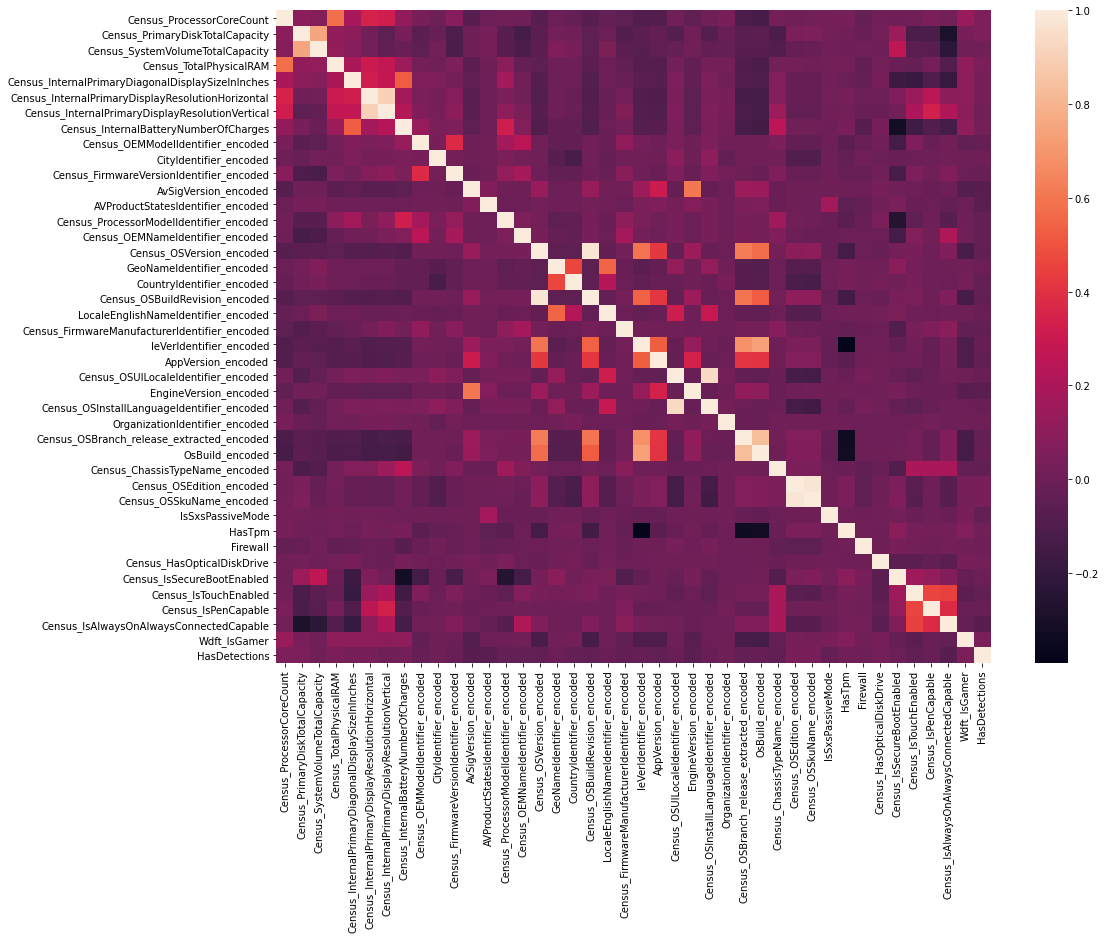

In [7]:
plt.subplots(figsize=(16,12))
sns.heatmap(df[numerical_columns + binary_columns].corr());

In [8]:
# check for categorical encoded nominal

In [9]:
# define function to create cdf dist plot
def cdf_dist_plots(columns, ncol=None, figsize=(15, 8)):
    if ncol is None:
        ncol = len(columns)
    nrow = int(np.ceil(len(columns) / ncol))
    #fig, axes = plt.subplots(nrow, ncol, figsize=figsize, squeeze=False)
    #fig.subplots_adjust(wspace=0.5, hspace=0.6)
    for i, col in enumerate(columns):
        #ax = axes.flatten()[i]
        ax = sns.displot(data=df, x=col, hue='HasDetections', kind='ecdf')
        ax.set(xlabel=col)
    nsubplots = nrow * ncol    
    for empty in range(i+1, nsubplots):
        axes.flatten()[empty].set_visible(False)

In [10]:
# define function to create kde dist plot
def kde_dist_plots(columns, ncol=None, figsize=(15, 8)):
    if ncol is None:
        ncol = len(columns)
    nrow = int(np.ceil(len(columns) / ncol))
    #fig, axes = plt.subplots(nrow, ncol, figsize=figsize, squeeze=False)
    #fig.subplots_adjust(wspace=0.5, hspace=0.6)
    for i, col in enumerate(columns):
        #ax = axes.flatten()[i]
        ax = sns.displot(data=df, x=col, hue='HasDetections', kind='kde')
        ax.set(xlabel=col)
    nsubplots = nrow * ncol    
    for empty in range(i+1, nsubplots):
        axes.flatten()[empty].set_visible(False)

C:\Users\marco\anaconda3\envs\capstone2env\lib\site-packages\seaborn\axisgrid.py:392: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)


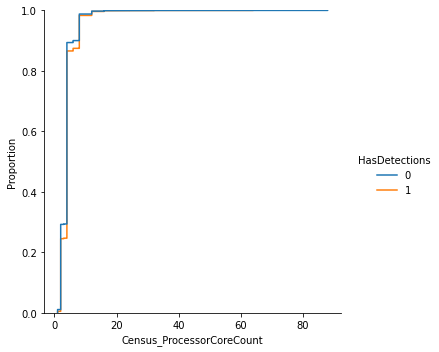

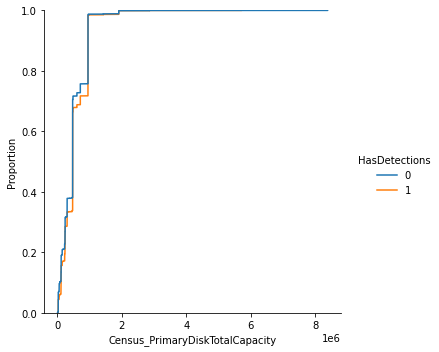

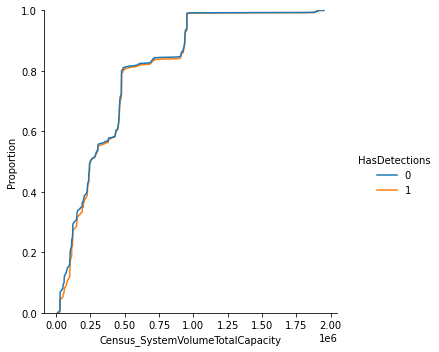

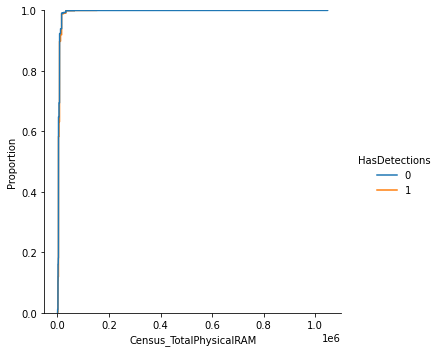

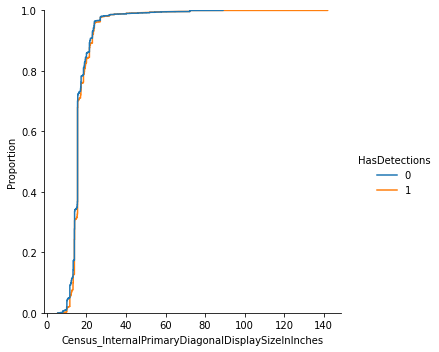

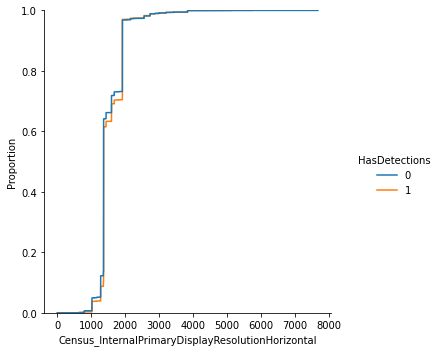

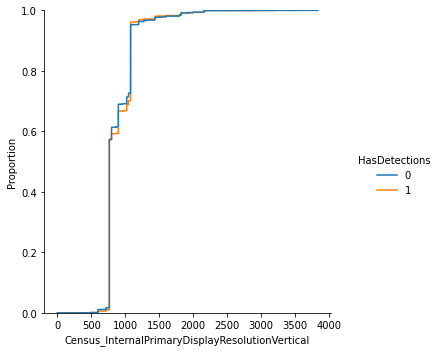

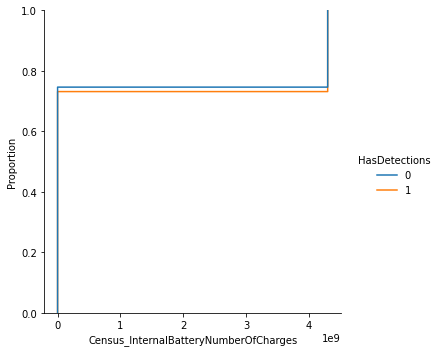

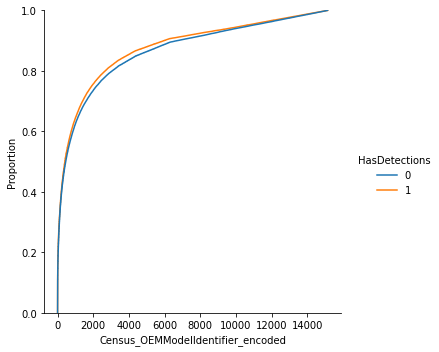

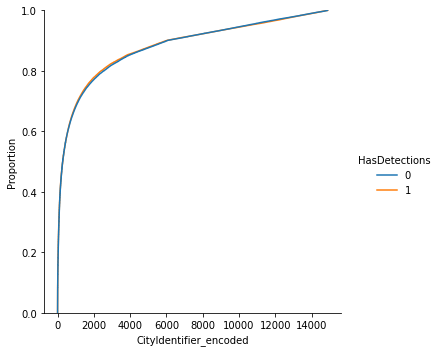

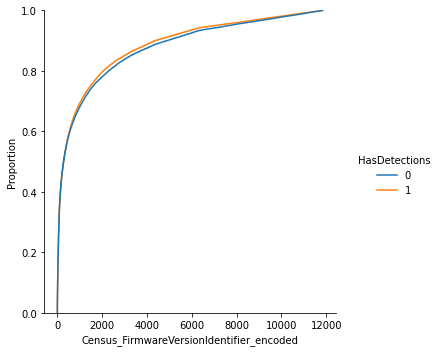

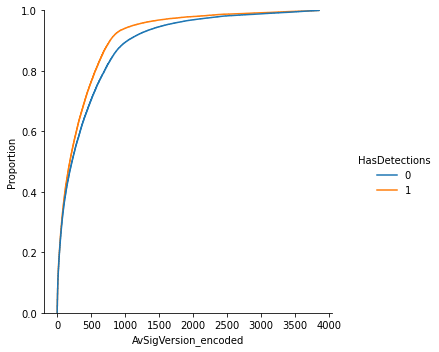

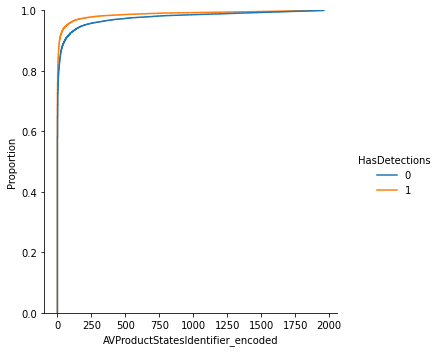

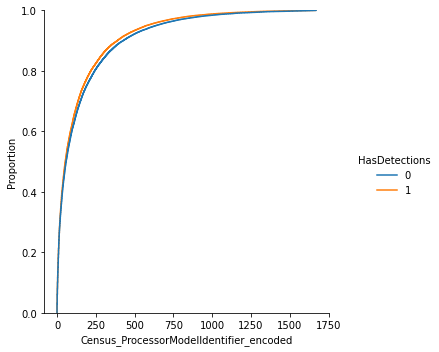

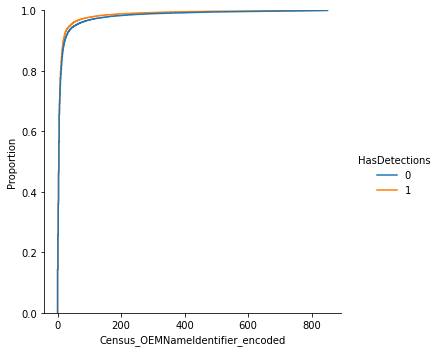

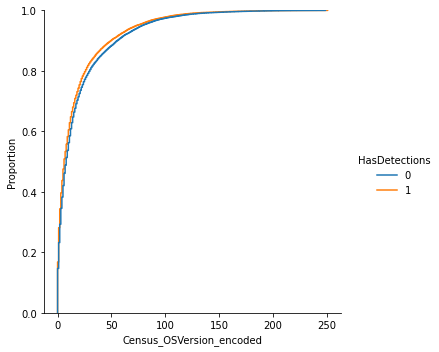

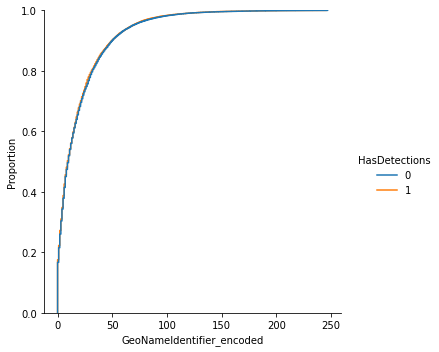

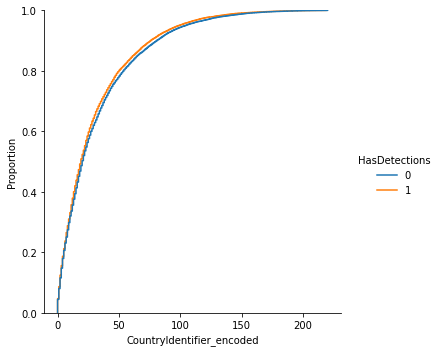

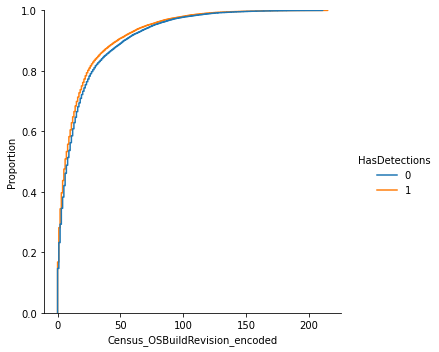

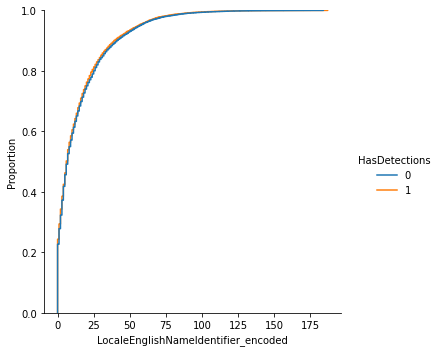

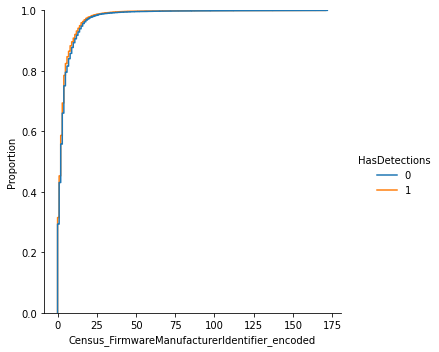

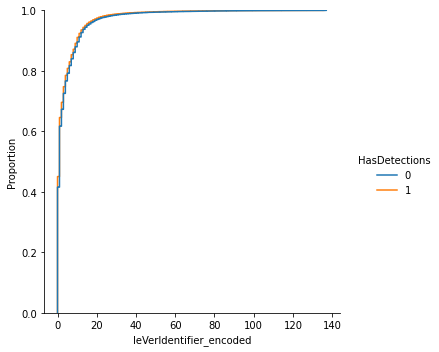

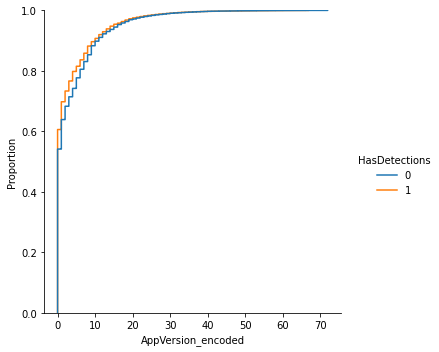

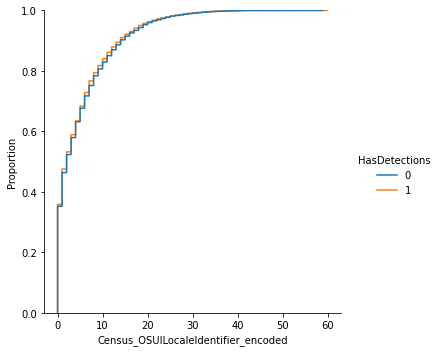

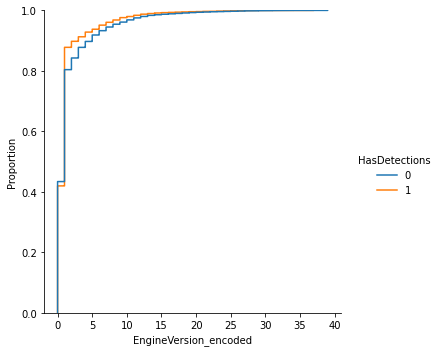

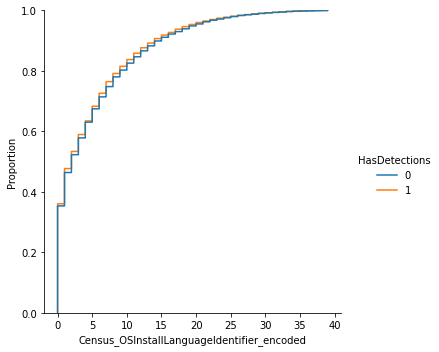

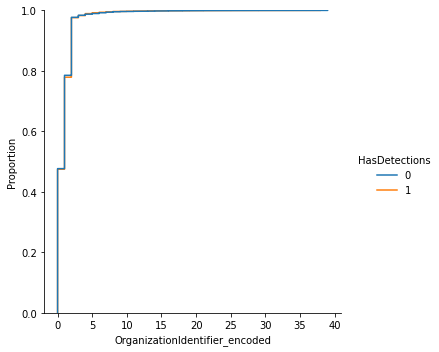

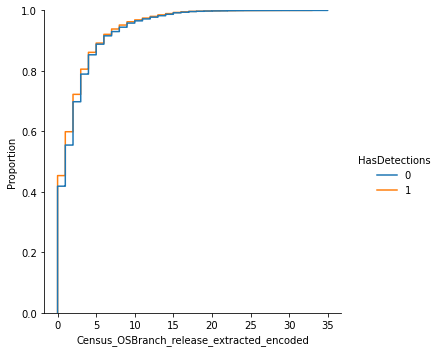

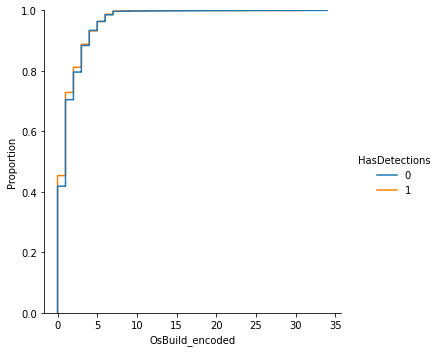

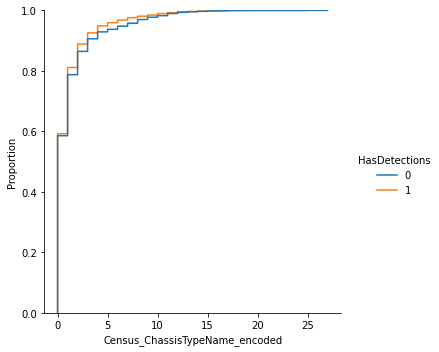

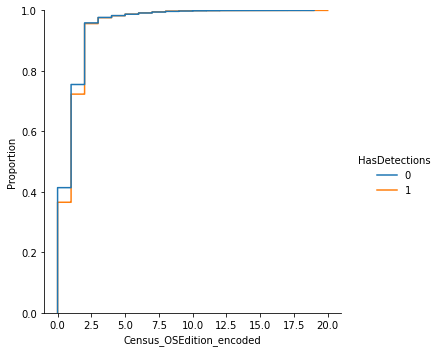

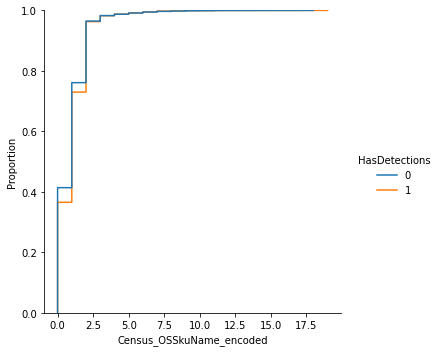

In [11]:
cdf_dist_plots(numerical_columns, figsize=(15, 15))

C:\Users\marco\anaconda3\envs\capstone2env\lib\site-packages\seaborn\axisgrid.py:392: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)


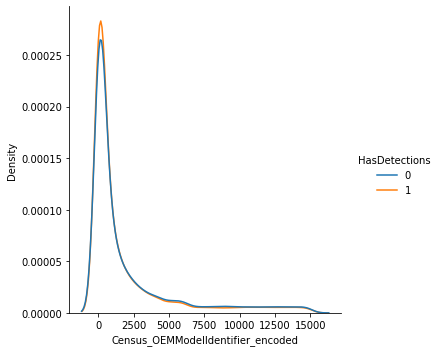

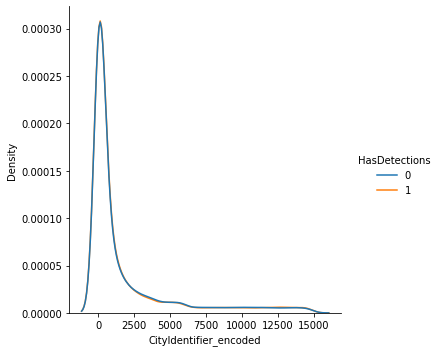

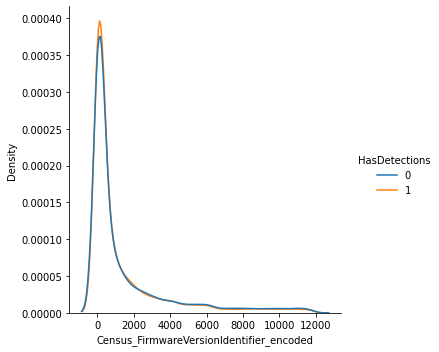

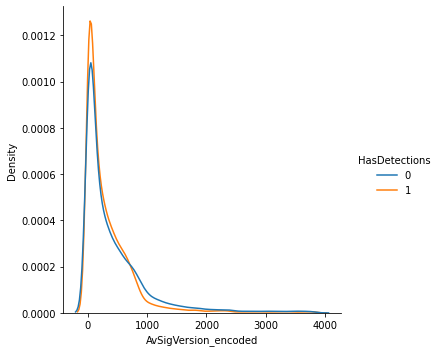

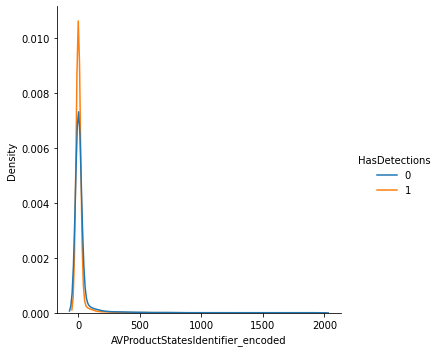

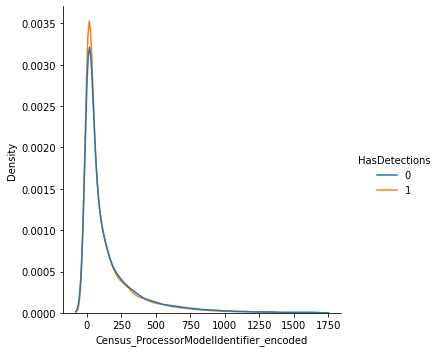

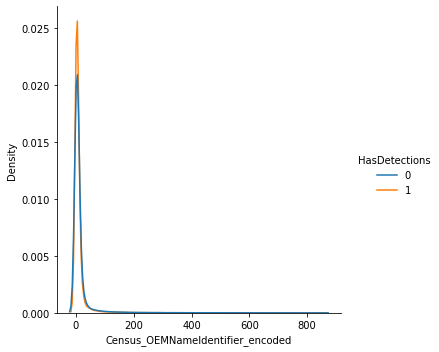

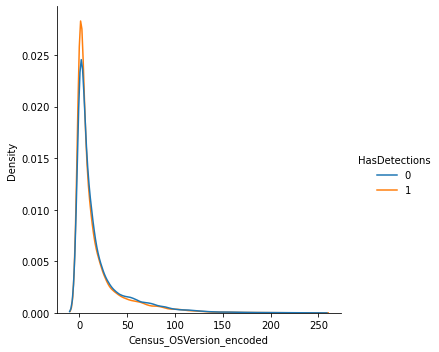

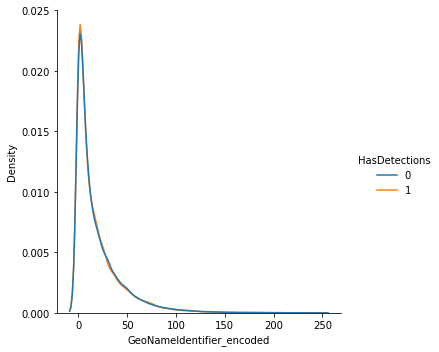

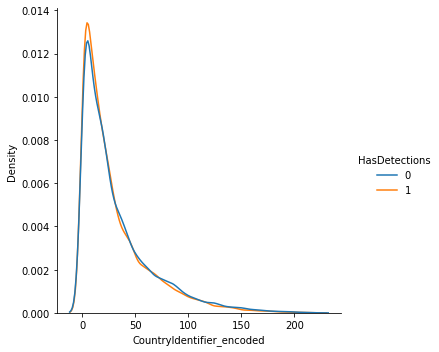

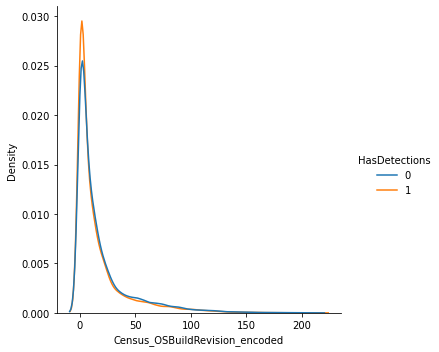

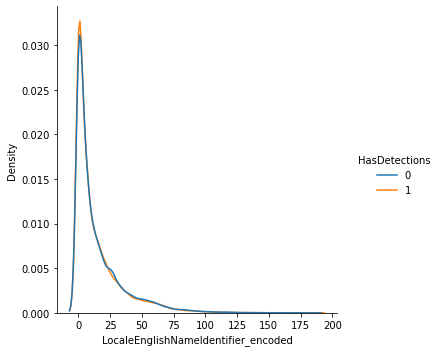

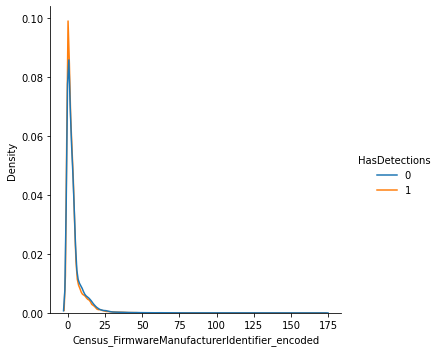

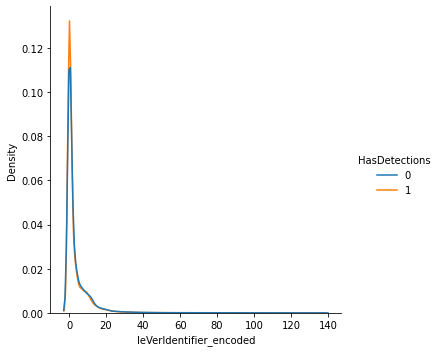

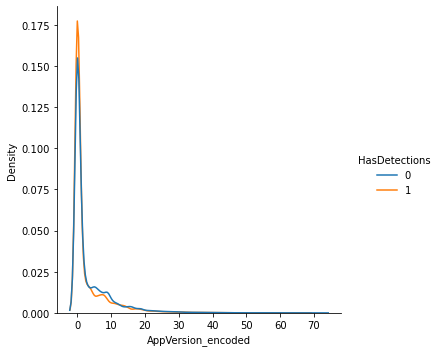

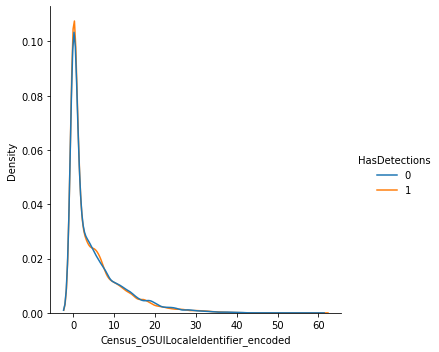

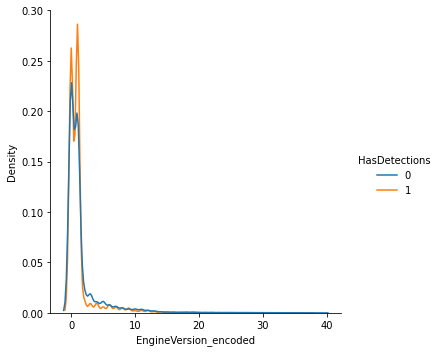

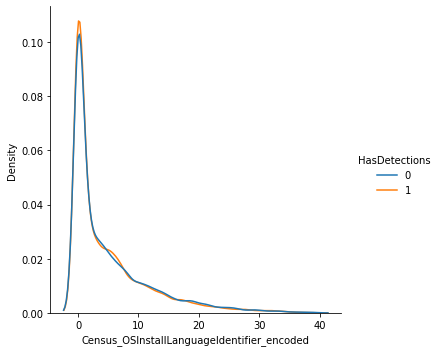

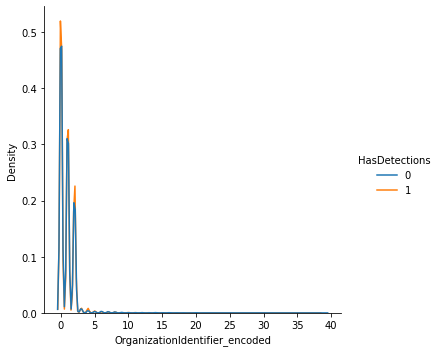

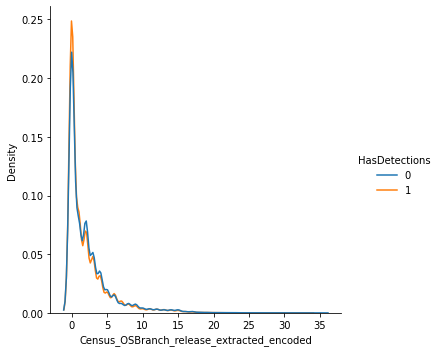

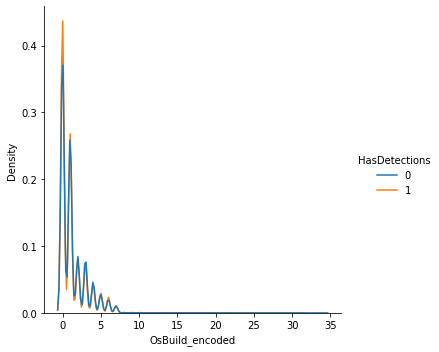

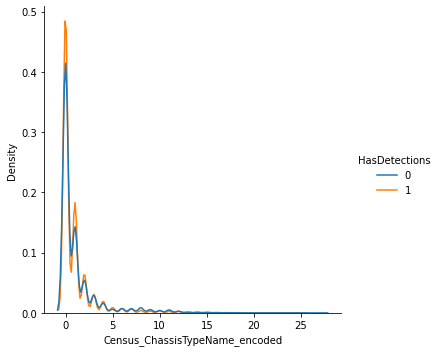

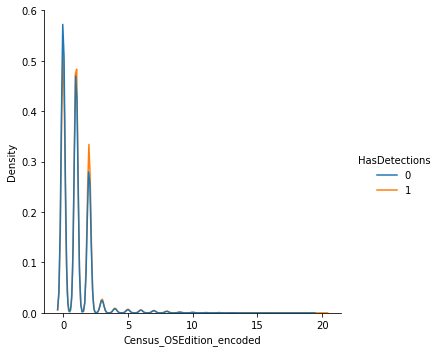

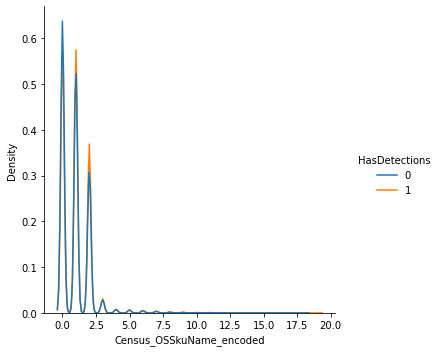

In [12]:
kde_dist_plots(rank_columns, figsize=(15, 15))

AvSigVersion, AVProductStateIdentifier, Census_ProcessorModelldentifier, Census_OEMNameIdentifier, Census_OSVersion, CountryIdentifier, Census_OSBuildRevision,Census_FirmwareManufacturerIdentifier

In [13]:
df[['Census_OEMModelIdentifier_encoded',
    'Census_FirmwareVersionIdentifier_encoded',
    'AvSigVersion_encoded', 
    'AVProductStatesIdentifier_encoded',
    'Census_ProcessorModelIdentifier_encoded', 
    'Census_OEMNameIdentifier_encoded', 
    'Census_OSVersion_encoded', 
    'CountryIdentifier_encoded', 
    'Census_OSBuildRevision_encoded', 
    'Census_FirmwareManufacturerIdentifier_encoded',
    'HasDetections']].corr()['HasDetections']

Census_OEMModelIdentifier_encoded               -0.023520
Census_FirmwareVersionIdentifier_encoded        -0.019252
AvSigVersion_encoded                            -0.074770
AVProductStatesIdentifier_encoded               -0.060823
Census_ProcessorModelIdentifier_encoded         -0.031034
Census_OEMNameIdentifier_encoded                -0.031681
Census_OSVersion_encoded                        -0.038882
CountryIdentifier_encoded                       -0.028753
Census_OSBuildRevision_encoded                  -0.039300
Census_FirmwareManufacturerIdentifier_encoded   -0.032782
HasDetections                                    1.000000
Name: HasDetections, dtype: float64

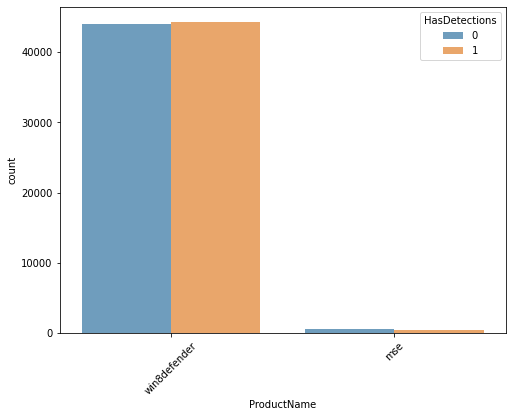

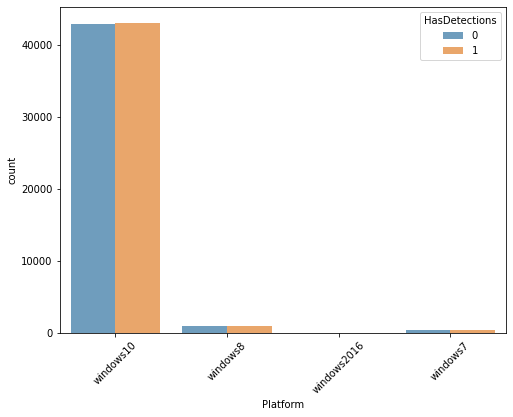

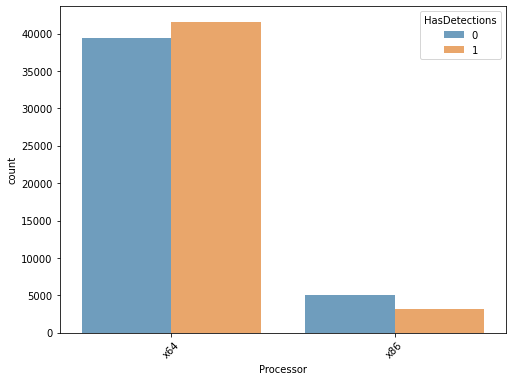

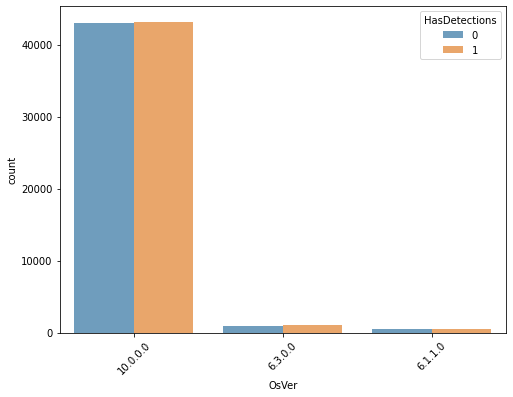

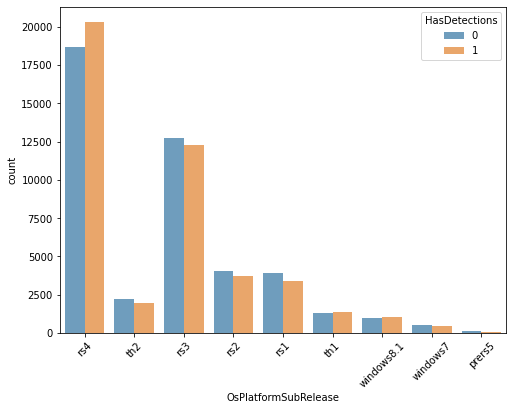

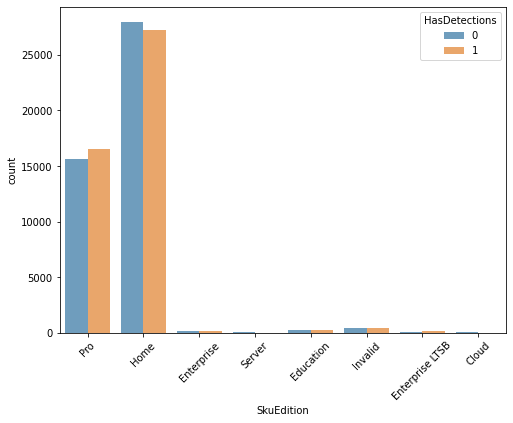

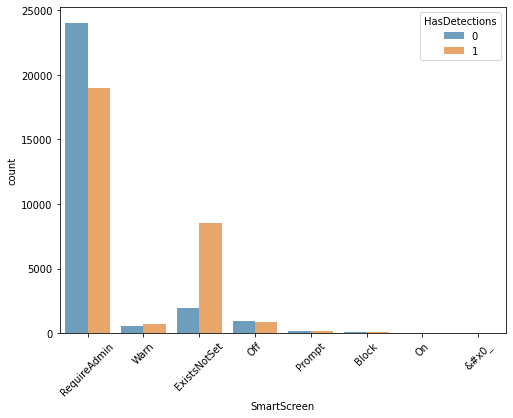

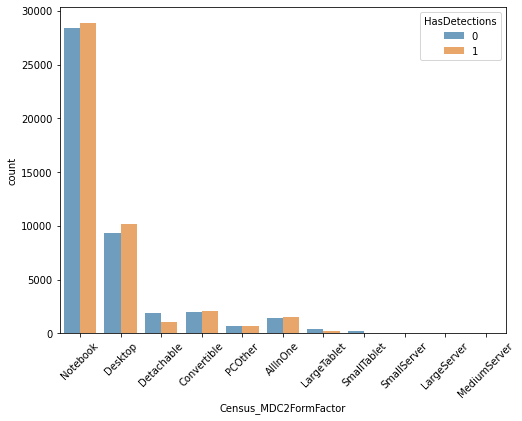

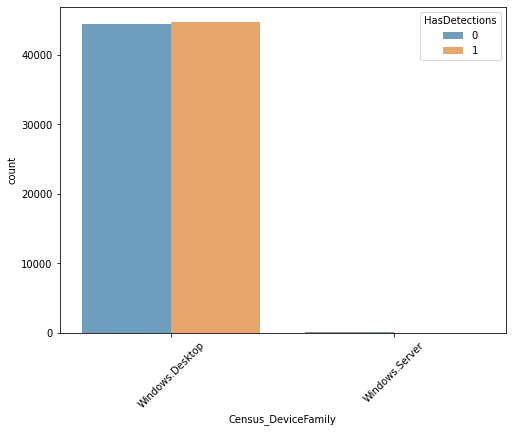

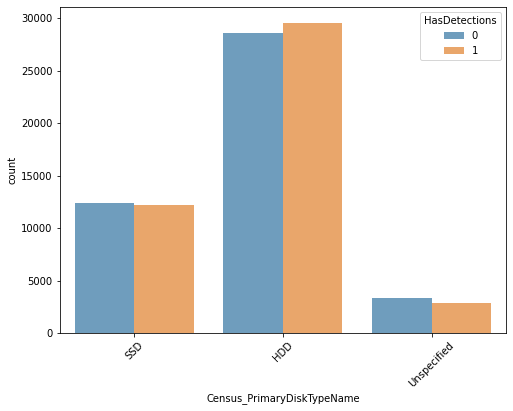

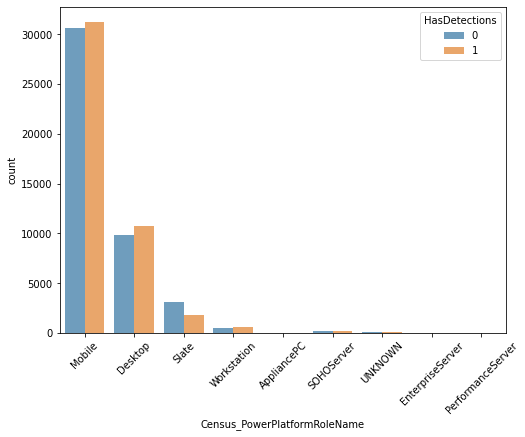

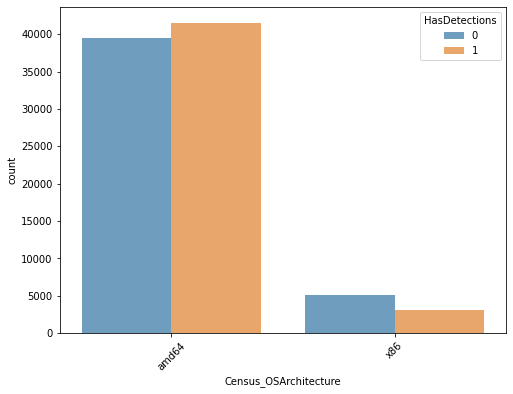

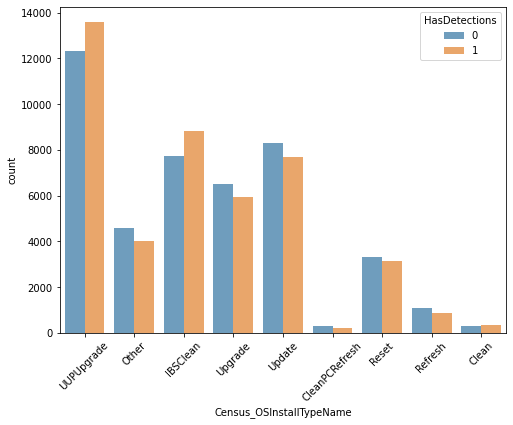

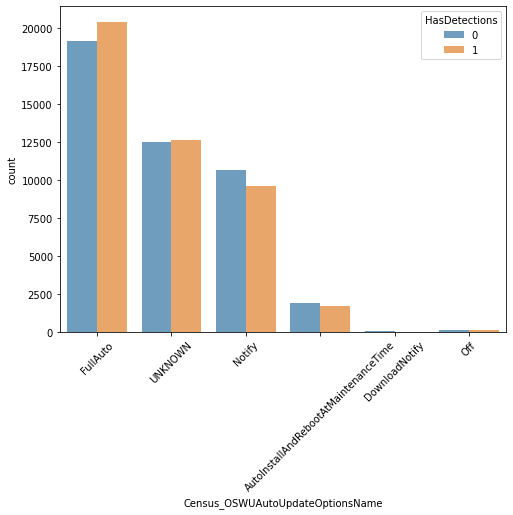

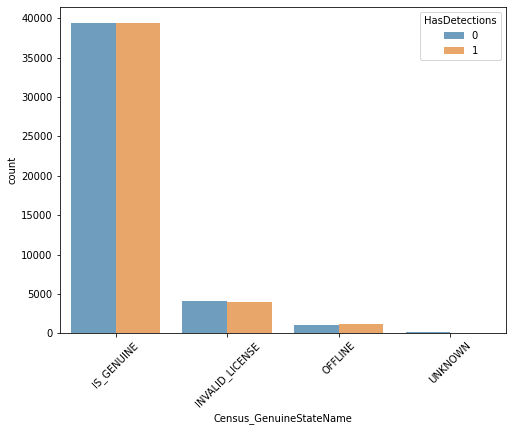

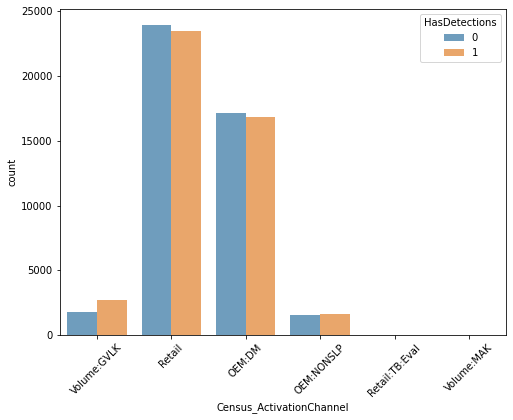

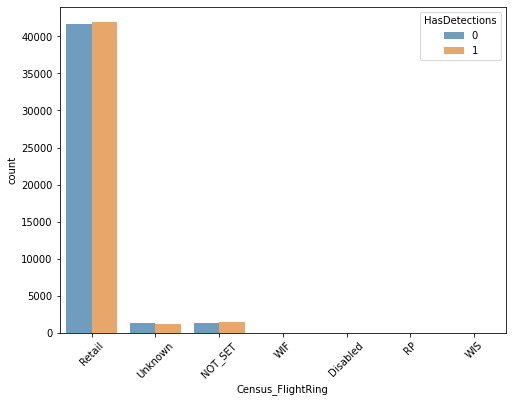

In [14]:
for col in categorical_columns:
    plt.figure(figsize=(8, 6))
    sns.countplot(x=col, hue='HasDetections', data=df, alpha=.7)
    plt.xticks(rotation=45); 

SmartScreen seems most predictive feature

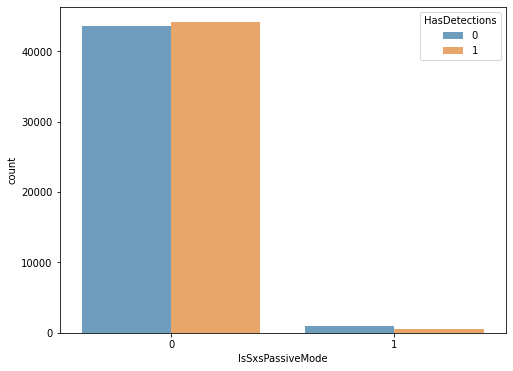

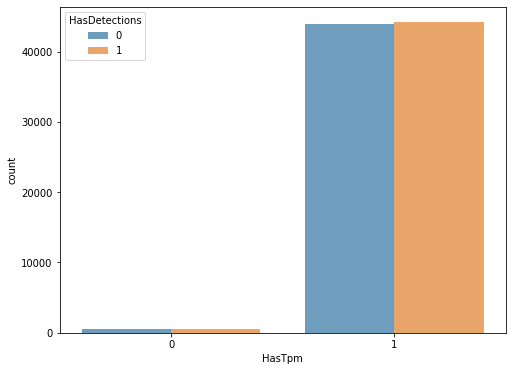

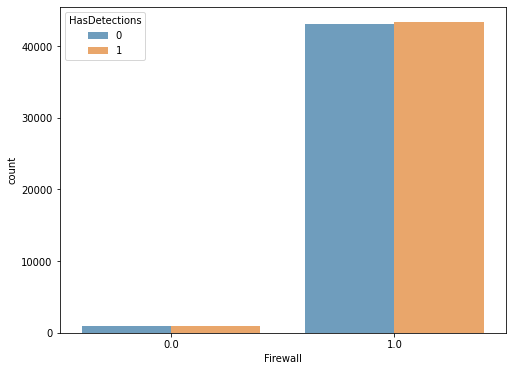

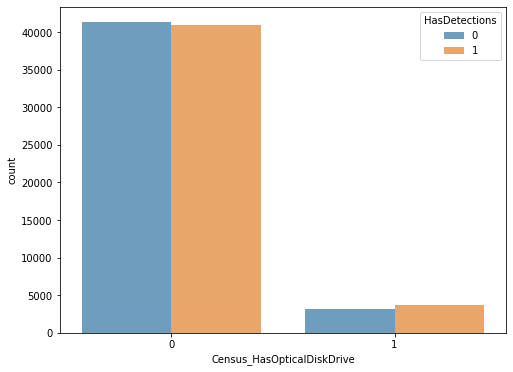

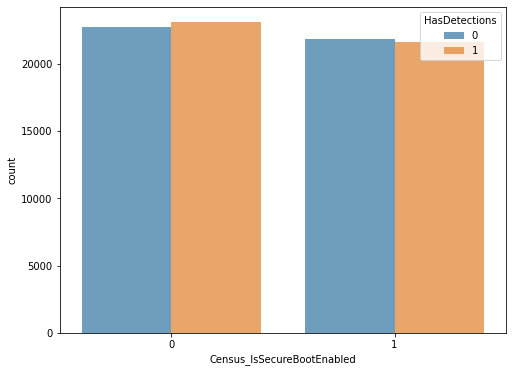

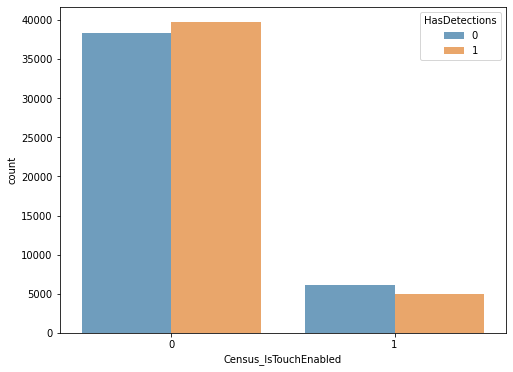

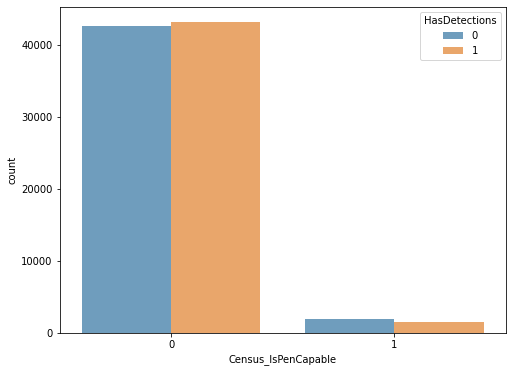

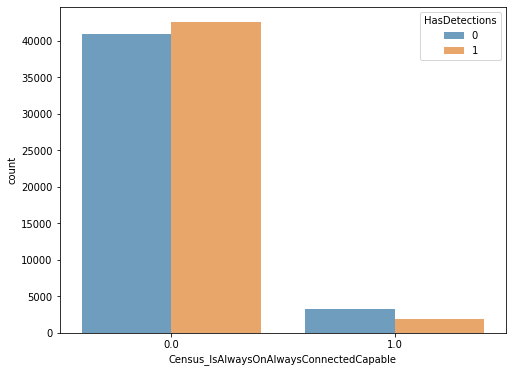

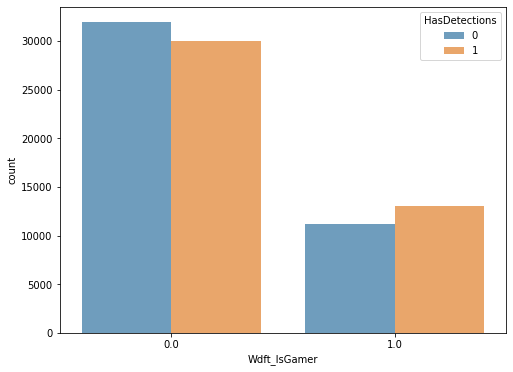

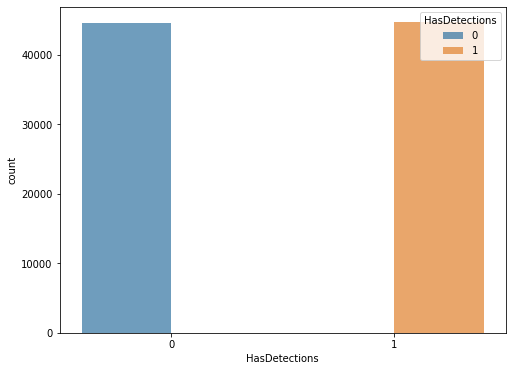

In [15]:
for col in binary_columns:
    plt.figure(figsize=(8, 6))
    sns.countplot(x=col, hue='HasDetections', data=df, alpha=.7)

<AxesSubplot:xlabel='IsProtected', ylabel='count'>

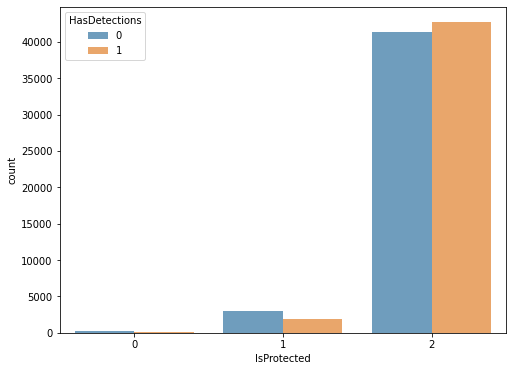

In [16]:
plt.figure(figsize=(8, 6))
sns.countplot(x='IsProtected', hue='HasDetections', data=df, alpha=.7)
